In [78]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [79]:
df_2024 = pd.read_parquet(r"C:\Users\Guest_Account\Desktop\Futures Strategies\Futures_2024.parquet", engine='pyarrow')
df_2023 = pd.read_parquet(r"C:\Users\Guest_Account\Desktop\Futures Strategies\Futures_2023.parquet", engine='pyarrow')

In [80]:
df = pd.concat([df_2023, df_2024])
df = df[[col for col in df.columns if 'Close' in col]]
price = df['AUROPHARMA_Close']
prices = price.to_frame(name=' AUROPHARMA Price')
prices.index = pd.to_datetime(prices.index)
prices.index.name = 'Datetime'
prices = prices.resample('30T', origin = '2023-01-02 09:15:00').last()
prices.dropna(inplace=True)

C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_8824\975647947.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  prices = prices.resample('30T', origin = '2023-01-02 09:15:00').last()


In [81]:
prices

,AUROPHARMA Price
Datetime,
2023-01-02 09:15:00,432.95
2023-01-02 09:45:00,433.00
2023-01-02 10:15:00,434.00
2023-01-02 10:45:00,433.80
2023-01-02 11:15:00,433.80
...,...
2024-07-02 13:15:00,1216.10
2024-07-02 13:45:00,1216.15
2024-07-02 14:15:00,1218.10


In [82]:
#Plan:
#Start with four contracts, and 100000 capital. 
#Every Day, calculate the new standard devation of returns up to that point (new formula as in book)
#Every Day, calculate N using formula.
#Calculate EWMA of prices up to that day, with two half lives.
#Combine signal of contracts N with EMWA crossover.


class FutureStrategyTwo:
    def __init__(self, price, initial_capital= 1000000, target_risk = 20):
        self.prices = prices
        self.mult = 550 #Found in other doc
        self.cash = initial_capital 
        self.targetrisk = target_risk #%, as found in book.
        self.position = 4
        self.trade_log = []
        self.capital_series = pd.Series(index=prices.index)
        self.capital_series.iloc[1] = initial_capital
        self.position_series = pd.Series(index=prices.index)


        self.sd_returns = self.calculate_returns_and_std_dev()
        self.ewma_16, self.ewma_256 = self.calculate_ewma_signals()

    
    def calculate_returns_and_std_dev(self):
        returns = (self.prices.diff() / self.prices.shift(1)) *100
        sd_returns_s = returns.ewm(span = 32).std()
        sd_returns_l = returns.ewm(span = 700).std()
        sd_returns = 0.3*sd_returns_l + 0.7*sd_returns_s
        sd_returns.index = self.prices.index
        
        return sd_returns*110  #(*sqrt(252)*sqrt(48)))
    
    def calculate_ewma_signals(self):
        ewma_16 = self.prices.ewm(span=64).mean()
        ewma_256 = self.prices.ewm(span=256).mean()
        ewma_16.index = self.prices.index
        ewma_256.index = self.prices.index
        return ewma_16, ewma_256


        
    def calculate_N(self, timestamp):
        price = self.prices.loc[timestamp]
        ewma_16_value = self.ewma_16.loc[timestamp].values
        ewma_256_value = self.ewma_256.loc[timestamp].values
        sgn = np.sign(ewma_16_value - ewma_256_value)

        num_of_contracts = (sgn *self.cash * self.targetrisk) / (price * self.mult * self.sd_returns.loc[timestamp])
 
        return int(num_of_contracts)   

    def buy_contract(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position += contracts
        self.cash -= contracts * price * self.mult
        self.trade_log.append((timestamp, 'BUY', contracts, price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position

    def sell_contract(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position -= contracts
        self.cash += contracts * price * self.mult
        self.trade_log.append((timestamp, 'SELL', contracts, price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position
    
    def no_trade(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position += contracts
        self.cash -= contracts * price * self.mult
        self.trade_log.append((timestamp, 'HOLD POSITION', price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position
    
    def trade(self, timestamp):
    
        num_of_contracts =  self.calculate_N(timestamp)

        if num_of_contracts!= 0:
            contracts_to_trade = num_of_contracts - self.position
        #elif num_of_contracts< 0:
            #contracts_to_trade = num_of_contracts - self.position
         

        else:
            contracts_to_trade = -self.position


        if (contracts_to_trade > 0) : 
            self.buy_contract(timestamp, contracts_to_trade)

        elif (contracts_to_trade < 0):
            self.sell_contract(timestamp, -(contracts_to_trade))
        
        else:
            self.no_trade(timestamp, 0) 

        
    def get_capital_progression(self):
        return self.capital_series

    def get_trade_log(self):
        return self.trade_log
    
    def get_position_series(self):
        return self.position_series
    
strategy = FutureStrategyTwo(prices)


for timestamp in prices.index[2:]:  
    strategy.trade(timestamp)

cap_progression = strategy.get_capital_progression()[1:]
print("Capital Progression Over Time:")
print(cap_progression)

trade_log = strategy.get_trade_log()
print("Trade Log:")
print(trade_log)

position_series = strategy.get_position_series()


C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_8824\3006393927.py:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(num_of_contracts)
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_8824\3006393927.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_8824\3006393927.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
C:\Users\Guest_Ac

Capital Progression Over Time:
Datetime
2023-01-02 09:45:00    1000000.0
2023-01-02 10:15:00    1002200.0
2023-01-02 10:45:00    1001650.0
2023-01-02 11:15:00    1001650.0
2023-01-02 11:45:00    1005362.5
                         ...    
2024-07-02 13:15:00     970685.0
2024-07-02 13:45:00     970657.5
2024-07-02 14:15:00     969585.0
2024-07-02 14:45:00     969475.0
2024-07-02 15:15:00     968787.5
Length: 4786, dtype: float64
Trade Log:
[(Timestamp('2023-01-02 10:15:00'), 'HOLD POSITION', AUROPHARMA Price    434.0
Name: 2023-01-02 10:15:00, dtype: float64), (Timestamp('2023-01-02 10:45:00'), 'BUY', 1, AUROPHARMA Price    433.8
Name: 2023-01-02 10:45:00, dtype: float64), (Timestamp('2023-01-02 11:15:00'), 'SELL', 1, AUROPHARMA Price    433.8
Name: 2023-01-02 11:15:00, dtype: float64), (Timestamp('2023-01-02 11:45:00'), 'SELL', 1, AUROPHARMA Price    436.05
Name: 2023-01-02 11:45:00, dtype: float64), (Timestamp('2023-01-02 12:15:00'), 'HOLD POSITION', AUROPHARMA Price    435.6
Name: 20

In [83]:
def trade_analysis(returns):
    
    plt.figure(figsize=(12, 6))
    plt.plot(returns, label='Cumulative PnL', color='blue')
    plt.title('Cumulative PnL', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('PnL', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    total_return = (returns.iloc[-1] / returns.iloc[0]) 
    number_of_years = ((returns.index[-1] - returns.index[0]).days) / 365
    average_annual_return = ((total_return) ** (1 / number_of_years) - 1)*100
    print(f"The CAGR is: {average_annual_return}%")
    
    mean_returns = returns.pct_change().mean()*252*100*24
    print(f"The Average Annual Return is: {mean_returns}%")
    
    std_returns = returns.pct_change().std()*(252**0.5) * 100 *(24**0.5)
    print(f"The Average Annual Percentage Risk is: {std_returns}%")
    
    sharpe = mean_returns / std_returns
    print(f"The Sharpe Ratio is: {sharpe}")


    plt.show()


In [84]:
def position_analysis(position_series):
    plt.figure(figsize=(12, 6))
    plt.plot(position_series, label='Position Size', color='blue')
    plt.title('Position Size over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Position', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    

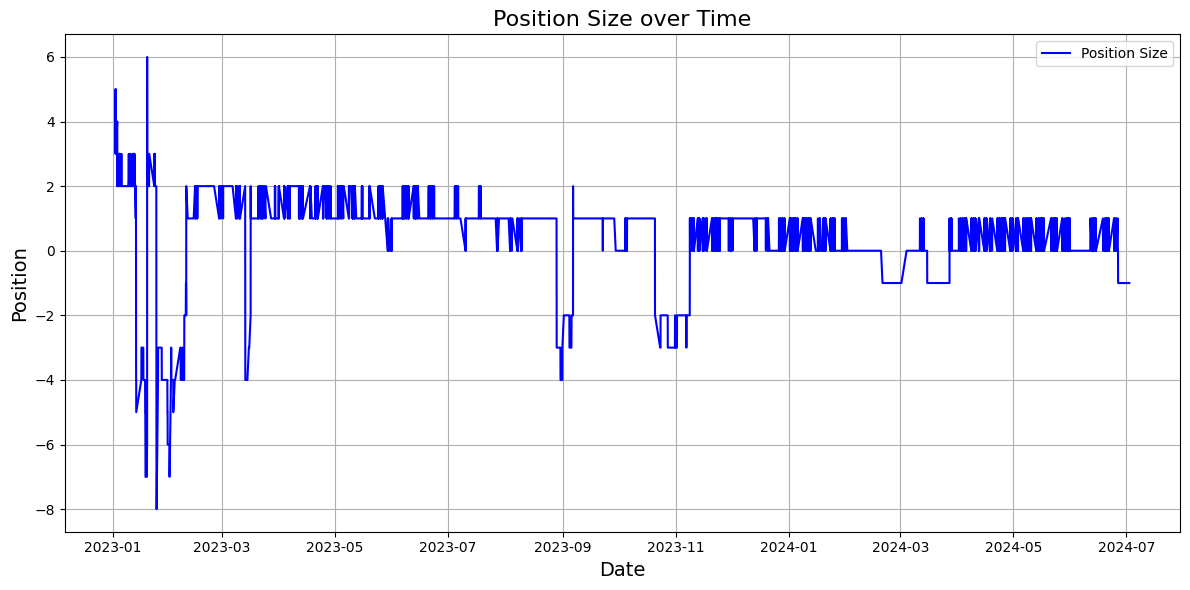

In [85]:
position_analysis(position_series)

The CAGR is: -2.093702874315917%
The Average Annual Return is: -2.4983426434164353%
The Average Annual Percentage Risk is: 17.37492133399771%
The Sharpe Ratio is: -0.14379015567269932


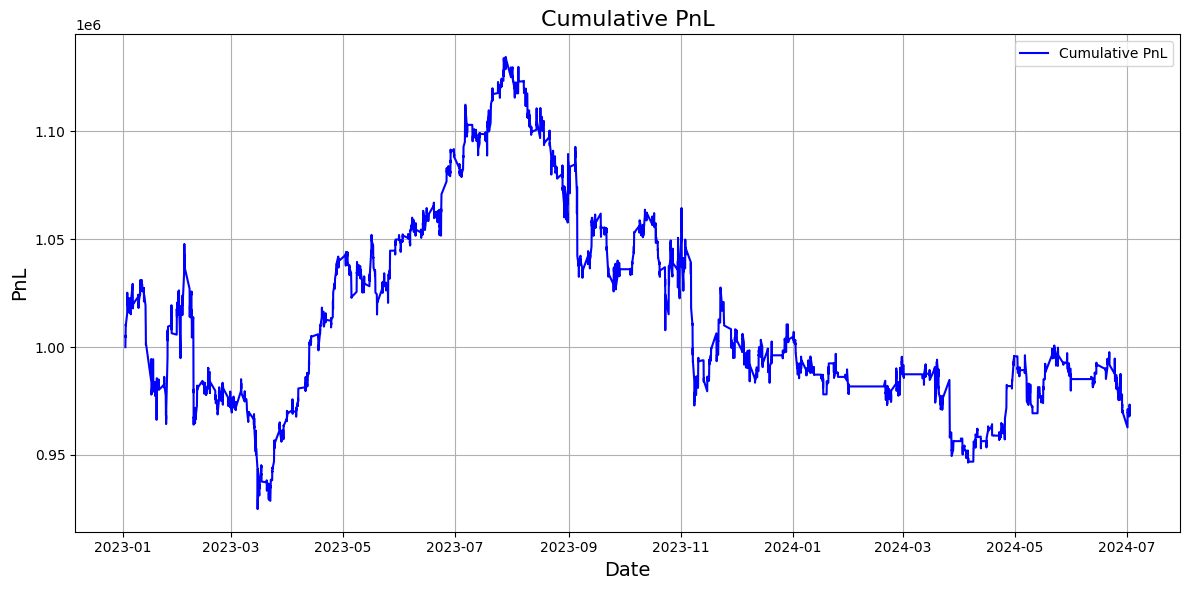

In [86]:
trade_analysis(cap_progression)

In [87]:
#As in the book, it is understandable why this strategy does worse. We have selected a stock with high returns over the 
#time period, so the long only strategies will generally do better than the long and short strategies.

In [88]:
#Notes

#Ways to improve:

#Add in stop loss orders. This would involve if statements determing if the price were to drop or rise to a certain level
#if we were long or short respectively then we would liquidate the position

#Add in multiple stocks to make one larger portfolio. Run each stock through the class and combine all returns into a 
#total return. We could implement portfolio optimisation to assign weights to the stocks. In the book, it just does it
#equally by asset class

#Add in trading costs - find them somewhere online and calcualte risk adjusted costs etc

#Try different indicators, and combine indicators

#Try trading with margin - liquidating positions if leverage becomes too high. Means we can allocate more capital to
#contracts.

#Use a different method for the target risk, I used Kelly's criterion from the book. There are others.

#Further analysis on portfolio returns - skew, tails, drawdowns.
